In [1]:
from typing import List, Tuple

In [13]:
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.transforms import Compose
from torchvision import transforms

import numpy as np

In [14]:
def stratified_split(classes_list: List[int], fraction=0.2) -> Tuple[List[int], List[int]]:
    """
    Return training and eval indices where each class is represented of
    the same fraction. Left element of tuple has _fraction_ amout of each class and 
    """
    indices = defaultdict(list)
    for i, k in enumerate(classes_list):
        indices[k].append(i)
    
    left_indices = []
    right_indices = []
    for k, sub_indices in indices.items():
        size = int(fraction*len(sub_indices) + .5)
        sub = np.random.choice(sub_indices, size, replace=False)
        left_indices.extend(sub)
        right_indices.extend([i for i in sub_indices if i not in sub])
    
    assert len(left_indices)+len(right_indices) == len(classes_list)
    assert not any(i in right_indices for i in left_indices)
    return left_indices, right_indices

class DataSubSet(Dataset):
    
    def __init__(self, ds: Dataset, indices: List[int], transform=None):
        self.ds = ds
        self.indices = indices
        self.transform = transform
        
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, item: int):
        i = self.ds[self.indices[item]]
        if self.transform is not None:
            img, *other = i
            return (self.transform(img), *other)
        return i

In [15]:
class SlimWide(nn.Module):

    def __init__(self, in_channels=1, channels=64):

        super().__init__()

        self.convnet1 = nn.Sequential(
                nn.Conv2d(in_channels, channels, kernel_size=5, padding=1, stride=1),
                #nn.BatchNorm2d(channels),
                nn.ReLU(True))

        self.convnet2 = nn.Sequential(
                nn.Conv2d(channels, channels, kernel_size=5, padding=1, stride=1),
                #nn.BatchNorm2d(channels),
                nn.ReLU(True))

        self.convnet3 = nn.Sequential(
                nn.Conv2d(channels, channels, kernel_size=5, padding=1, stride=1),
                nn.BatchNorm2d(channels),
                nn.AvgPool2d(kernel_size=2, stride=2), nn.ReLU(True))
        self.convnet4 = nn.Sequential(
                nn.Conv2d(channels, channels, kernel_size=5, padding=1, stride=1),
                nn.BatchNorm2d(channels),
                nn.AvgPool2d(kernel_size=2, stride=2), nn.ReLU(True))
        
        self.convnet4 = nn.Conv2d(channels, 1, kernel_size=1, padding=0, stride=1)
        self.scalar = nn.Parameter(data=torch.tensor([1.0]))
        self.bias = nn.Parameter(data=torch.tensor([0.0]))
        
    def forward(self, x):
        y = self.convnet1(x)
        y = self.convnet2(y)
        y = self.convnet3(y)
        y = self.convnet4(y)
        
        return self.scalar * y - self.bias

In [16]:
def torchvision_default_initialize_layer(m):
    # Recent init from torch repo.
    if isinstance(m, nn.Conv2d):
        if m.bias is not None:
            m.bias.data.zero_()
        nn.init.kaiming_normal_(m.weight)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.constant_(m.bias, 0)
        nn.init.normal_(m.weight, 0.01)
        
def torchvision_default_initialize_weights(module):
    for m in module.modules():
        torchvision_default_initialize_layer(m)

In [17]:
tf_eval = Compose([transforms.Grayscale(),
                   transforms.ToTensor(),
                   transforms.Normalize((0.4862745,), (0.1388,)),
                  ])

tf_train = Compose([transforms.Grayscale(),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4862745,), (0.1388,)),
                   ])

ds = ImageFolder('../photomask_trainingdata')
eval_idx, train_idx = stratified_split([x[1] for x in ds.samples])

ds_eval = DataSubSet(ds, eval_idx, transform=tf_eval)
ds_train = DataSubSet(ds, train_idx, transform=tf_train)

In [18]:
m = SlimWide()
torchvision_default_initialize_weights(m)

In [19]:
def sorted_sums(ds, m):
    sums = defaultdict(list)
    for i in range(len(ds)):
        x, label = ds[i]
        y = m(x.unsqueeze(0))
        s = y.sum().item()
        sums[label].append(s)
    return {k: sorted(v) for k,v in sums.items()}

Text(0.5, 1.0, 'EVAL')

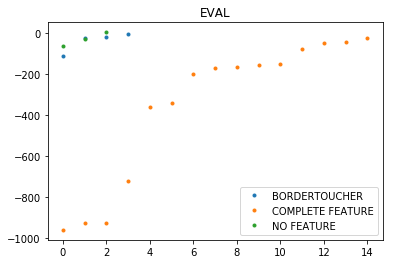

In [20]:
r = sorted_sums(ds_eval, m)
for k, v in r.items():
    label = label={v:k for k,v in ds.class_to_idx.items()}[k]
    plt.plot(v, ".", label=label)
plt.legend()
plt.title("EVAL")

Text(0.5, 1.0, 'TRAIN')

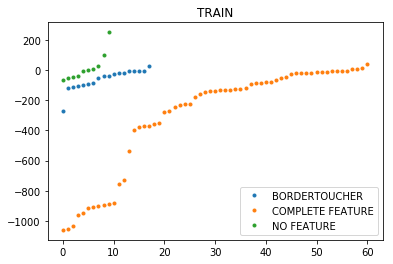

In [21]:
r = sorted_sums(ds_train, m)
for k, v in r.items():
    label = label={v:k for k,v in ds.class_to_idx.items()}[k]
    plt.plot(v, ".", label=label)
plt.legend()
plt.title("TRAIN")

In [258]:
TRUTH_BOUNDS = {"NO FEATURE": (0, 100),
                "COMPLETE FEATURE": (1500, 4000), 
                "BORDERTOUCHER" : (1000, 3500)
               }

In [22]:
def plot_pred(img, label):
    plt.imshow(img)
    plt.title(label)

In [23]:
def get_label(ds, k:int) -> str:
    return {v:k for k,v in ds.class_to_idx.items()}[k]

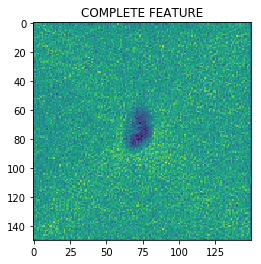

In [24]:
x, cls = ds_eval[11]
x = x.unsqueeze(0)
label = get_label(ds, cls)

y_mask = m(x).data.cpu().squeeze(1)[0].numpy()
plot_pred(x.numpy().squeeze(), label+" INPUT")
plot_pred(y_mask, label)

In [163]:
def loss_hinge(result_sum, min_sum:float = 2000, max_sum:float = 6000):
    loss = F.relu(result_sum - max_sum) + \
           F.relu(-result_sum + min_sum)
    return loss

losses = []
for s in torch.linspace(0, 100, 100):
    losses.append(loss_hinge(s, 40, 80))

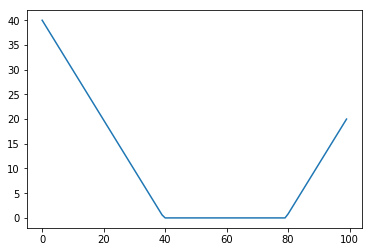

In [164]:
plt.plot(losses)